# Algorytm Kirkpatricka

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kirkpatrick_algorithm.visualizer.main import Visualizer
import random as rnd_gen
from enum import Enum
from sortedcontainers import SortedSet
import matplotlib

# Funkcje rysujące

In [2]:
def draw_polygon(polygon):
    vis = Visualizer()
    vis.add_point(polygon)
    vis.add_polygon(polygon, fill=False)
    vis.show()

In [3]:
def draw_polygon_colors(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in range(len(polygon)):
        if colors[i]==0:
            points_start.append(polygon[i])
        elif colors[i]==1:
            points_end.append(polygon[i])
        elif colors[i]==2:
            points_connect.append(polygon[i])
        elif colors[i]==3:
            points_divide.append(polygon[i])
        elif colors[i]==4:
            points_regular.append(polygon[i])

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [4]:
def draw_polygon_colors_dict(polygon,colors):
    points_start=[]
    points_end=[]
    points_connect=[]
    points_divide=[]
    points_regular=[]
    for i in polygon:
        if colors[i]==0:
            points_start.append(i)
        elif colors[i]==1:
            points_end.append(i)
        elif colors[i]==2:
            points_connect.append(i)
        elif colors[i]==3:
            points_divide.append(i)
        elif colors[i]==4:
            points_regular.append(i)

    vis = Visualizer()
    colors_start = ['green']
    color_end=['red']
    color_connect=['blue']
    color_divide=['cyan']
    color_regular=['#3B240B']
    vis.add_polygon(polygon, fill=False)
    vis.add_point(points_start, color=colors_start)
    vis.add_point(points_end, color=color_end)
    vis.add_point(points_connect, color=color_connect)
    vis.add_point(points_divide, color=color_divide)
    vis.add_point(points_regular, color=color_regular)
    vis.show()

In [5]:
def draw_polygon_triangulation(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)

    for a, b in tri:
        vis.add_line_segment([polygon[a], polygon[b]], color='red')
    vis.show()

In [6]:
def draw_polygon_tri(polygon,tri):
    vis = Visualizer()
    points = polygon
    tri_line_segments = tri
    vis.add_polygon(points, fill=False)
    vis.add_point(points)
    vis.add_line_segment(tri_line_segments, color='red')
    vis.show()

# Przykładowe wielokąty

In [7]:
polygon_example_1 = [(5,5), (3,4), (6,3), (4,2), (6,0), (7,1), (8,4)]
polygon_example_2 = [(2,0), (5,1), (6,0), (8,3), (7,2), (8,7), (6,9), (5,8), (2,9), (1,7), (2,4), (4,5), (3,6), (5, 7), (5.5, 3), (2,2), (1,3), (0,1)]

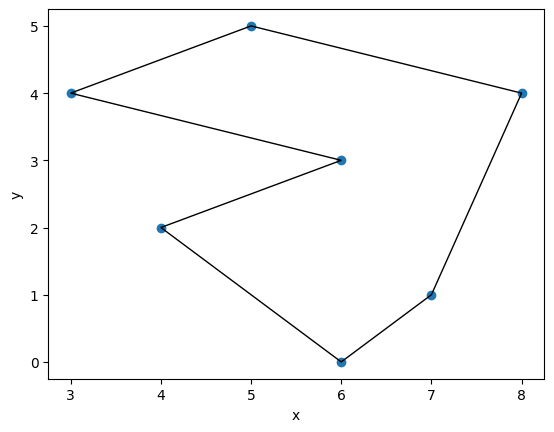

In [8]:
draw_polygon(polygon_example_1)

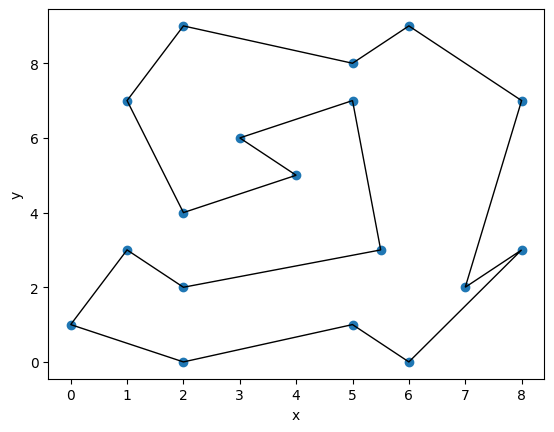

In [9]:
draw_polygon(polygon_example_2)

# Funkcja pozwalająca zadać wielokąt myszką

In [18]:
def get_polygon_points(max_x, max_y, points_data):
    %matplotlib inline
    fig = plt.figure()
    fig.set_label('Polygon Points')
    ax = fig.add_subplot(111)
    ax.set_title(f"Please select points for the polygon in counter-clockwise order")
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_y])

    cid = None

    def onclick(event):
        plt.plot(event.xdata, event.ydata, 'bo')
        points_data.append((event.xdata, event.ydata))
        ax.annotate(f"{len(points_data)}", xy=(event.xdata, event.ydata))
        fig.canvas.draw()

    def on_close(event):
        fig.canvas.mpl_disconnect(cid)
        plt.close(fig)
        %matplotlib inline
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    cid = fig.canvas.mpl_connect('close_event', on_close)
    plt.show()

In [17]:
polygon = []
get_polygon_points(10, 10, polygon)

In [40]:
print(polygon)

[]


## Funkcja sprawdzająca czy wielokąt jest y monotoniczny

In [151]:
EPS = 10**-14

In [21]:
def find_min_y_point(polygon):
    N = len(polygon)
    
    i_min_point = 0
    for i in range(1, N):
        if polygon[i][1] < polygon[i_min_point][1]:
            i_min_point = i

    return i_min_point

In [22]:
def is_y_monotonic(polygon):
    """
    Funkcja określa czy podana figura jest y-monotoniczna.
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: wartość bool - true, jeśli wielokąt jest monotoniczny i false jeśli nie jest
    """
    N = len(polygon)
    i_min_point = find_min_y_point(polygon)
    
    class Direction(Enum):
        UP = 0
        DOWN = 1
        
    dir = Direction.UP
    
    i = (i_min_point + 1) % N
    while i != i_min_point:
        if dir == Direction.UP:
            if polygon[i][1] <= polygon[i-1][1]:
                dir = Direction.DOWN
        elif dir == Direction.DOWN:
            if polygon[i][1] > polygon[i-1][1]:
                return False

        i += 1
        i %= N

    return True

## Funkcja do triangulacji wielokątów y-monotonicznych 

Funkcja obliczająca wyznacznik macierzy tworzenej przez punkty A, B, C

In [23]:
def det(a ,b, c):
    '''
    Funkcja zwraca wyznacznik macierzy 2x2 iloczynu wektorowego miedzy wektorami ab bc
    '''
    return (b[0] - a[0])*(c[1]-b[1]) - (b[1]-a[1])*(c[0]-b[0])

Enum opisujący rozważany łańcuch

In [24]:
class Chain(Enum):
    LEFT = 0
    RIGHT = 1

Funkcja oznaczająca przynależność punktów do danego łańcucha

In [25]:
def get_chains(polygon):
    N = len(polygon)
    i_min_point = find_min_y_point(polygon)
    chains = [-1]*N
    
    class Direction(Enum):
        UP = 0
        DOWN = 1
        
    dir = Direction.UP
    
    i = (i_min_point + 1) % N
    while i != i_min_point:
        if dir == Direction.UP:
            if polygon[i][1] <= polygon[i-1][1]:
                dir = Direction.DOWN
                chains[i] = Chain.LEFT.value
            else:
                chains[i] = Chain.RIGHT.value
        elif dir == Direction.DOWN:
            chains[i] = Chain.LEFT.value

        i += 1
        i %= N
    
    chains[i_min_point]  = Chain.LEFT.value

    return chains

Funkcja sprawdzająca czy sprawdzana krawędź jest "legalna"

In [152]:
def check_triangle(polygon, chains, a, b, c):
    d = det(polygon[a], polygon[b], polygon[c])
    
    if chains[b] == Chain.LEFT.value:
        return d > EPS
    else:
        return d < -EPS

Funkcja dodająca przekątną do zbioru przekątnych, sprawdza czy nie dodaliśmy za dużo przekątnych i czy nie próbujemy dodać krawędzi wielokąta

In [27]:
def add_diagonal(diagonals, n, a, b):
    if abs(a - b) == 1:
        return
    
    if (a == 0 and b == n - 1) or (a == n - 1 and b == 0):
        return
    
    if len(diagonals) < n - 2:
        diagonals.add((a, b))

Właściwa funkcja do obliczania triangulacji, złożoność $\mathcal{O} (n \log n)$

In [181]:
def triangulation(polygon):
    """
    Funkcja dokonuje triangulacji wielokąta monotonicznego. 
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica krotek dodawanych po kolei przekątnych np: [(1,5),(2,3)], oznacza, że triangulacja polega na dodaniu przekątnej pomiędzy wierzchołki 1-5 i 2-3
    """
    N = len(polygon)

    if not is_y_monotonic(polygon):
        return []
    
    chains = get_chains(polygon)
    indices = [i for i in range(N)]
    indices.sort(key=lambda x: polygon[x][1], reverse=True)

    S = [indices[0], indices[1]]

    diagonals = set()
    triangles = []

    for i in range(2, N):
        if chains[S[-1]] != chains[indices[i]]:
            while len(S) > 0:
                p = S.pop()
                add_diagonal(diagonals, N, indices[i], p)
                if S:
                    triangles.append((S[-1], p, indices[i]))

            S.append(indices[i - 1])
            S.append(indices[i])
        else:
            p = S.pop()
            while len(S) > 0 and check_triangle(polygon, chains, S[-1], p, indices[i]):
                add_diagonal(diagonals, N, indices[i], S[-1])
                add_diagonal(diagonals, N, indices[i], p)
                triangles.append((S[-1], p, indices[i]))

                p = S.pop()
            
            S.append(p)
            S.append(indices[i])
    
    return list(diagonals), triangles

# Triangulacja dowolnych wielokątów

## Funkcja określająca rodzaj wierzchołków 

In [48]:
class VertexType(Enum):
    START = 0
    END = 1
    CONNECT = 2
    DIVIDE = 3
    REGULAR = 4

In [49]:
def classify_point(polygon, T, i):
    N = len(polygon)
    
    angle = det(polygon[i-1], polygon[i], polygon[(i+1)%N])
        
    if angle > 0 and polygon[(i + 1)%N][1] < polygon[i][1] and polygon[i-1][1] < polygon[i][1]:
        T[i] = VertexType.START
    elif angle > 0 and polygon[(i + 1)%N][1] > polygon[i][1] and polygon[i-1][1] > polygon[i][1]:
        T[i] = VertexType.END
    elif angle < 0 and polygon[(i + 1)%N][1] < polygon[i][1] and polygon[i-1][1] < polygon[i][1]:
        T[i] = VertexType.DIVIDE
    elif angle < 0 and polygon[(i + 1)%N][1] > polygon[i][1] and polygon[i-1][1] > polygon[i][1]:
        T[i] = VertexType.CONNECT
    else:
        T[i] = VertexType.REGULAR

In [50]:
def color_vertex(polygon):
    """

    Funkcja dzieli wierzchołki na kategorie i przypisuje wierzchołkom odpowiednie numery: 0 - początkowy, 1 - końcowy, 2 - łączący, 3 - dzielący, 4 - prawdiłowy
    :param polygon: tablica krotek punktów na płaszczyźnie euklidesowej podanych przeciwnie do ruchu wskazówek zegara - nasz wielokąt
    :return: tablica o długości n, gdzie n = len(polygon), zawierająca cyfry z przedziału 0 - 4, gdzie T[i] odpowiada kategorii i-tego wierzchołka.
    """

    N = len(polygon)
    T = [VertexType.REGULAR]*N

    i_min_point = find_min_y_point(polygon)
    classify_point(polygon, T, i_min_point)

    i = (i_min_point + 1)%N
    while i != i_min_point:
        classify_point(polygon, T, i)

        i += 1
        i %= N
        

    return T

## Konwersja polygonu do formatu podwójnie łączonej listy krawędzi

In [90]:
class Vertex:
    def __init__(self):
        self.point_coords = None
        self.incident_halfedge = None
        self.index = -1

    def __str__(self):
        return str(self.point_coords)

In [85]:
class HalfEdge:
    def __init__(self):
        self.prev:HalfEdge = None
        self.next: HalfEdge = None
        self.twin: HalfEdge = None
        self.origin: Vertex = None
        self.incident_face = None
    
    def __str__(self):
        return str(self.origin)

In [86]:
class Face:
    def __init__(self):
        self.incident_edge: HalfEdge = None

In [140]:
def get_doubly_connected_edge_list(polygon):
    N = len(polygon)

    vertices = []
    for i in range(N):
        vertex = Vertex()
        vertex.point_coords = polygon[i]
        vertex.index = i
        vertices.append(vertex)


    f1 = lambda x: x + 1 if -1 <= x <= 0 else (-x + 1 if 0 <= x <= 1 else 0)
    f2 = lambda x: x  if 0 <= x <= 1 else (-x + 2 if 1 <= x <= 2 else 0)
    f = lambda x: f1(x)*f2(x)
    

    halfedges = []

    for i in range(N):
        current_halfedge = HalfEdge()
        current_halfedge.origin = vertices[i]
        current_halfedge.origin.incident_halfedge = current_halfedge
        
        opposite_halfedge = HalfEdge()
        opposite_halfedge.origin = vertices[i-1]
        opposite_halfedge.origin.incident_halfedge = opposite_halfedge

        current_halfedge.twin = opposite_halfedge
        opposite_halfedge.twin = current_halfedge

        halfedges.append(current_halfedge)


    for i in range(N - 1, -1, -1):
        e1, e2 = halfedges[i], halfedges[i - 1]
        e2.twin.next = e2.twin
        e2.prev = e1.twin

    face = Face()
    face.incident_edge = halfedges[0]

    return face
            

In [141]:
face = get_doubly_connected_edge_list(polygon_example_1)

In [142]:
def traverse(face: Face):
    e = face.incident_edge
    start_e = e
    vis = Visualizer()
    while True:
        vis.add_point(e.origin.point_coords)
        vis.show()
        e = e.next

        if e is start_e:
            break

    return vis

AttributeError: 'NoneType' object has no attribute 'origin'

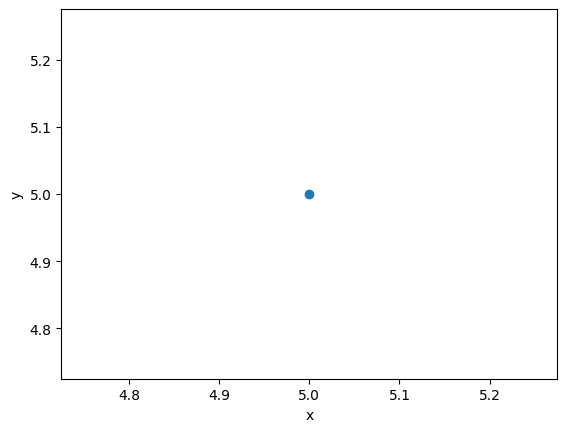

In [143]:
vis = traverse(face)

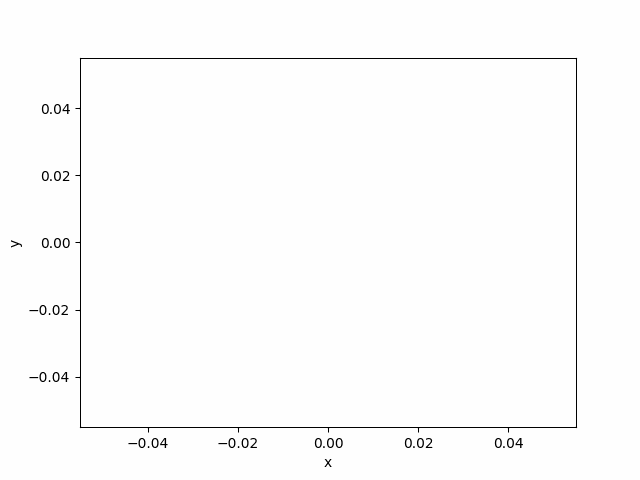

In [132]:
vis.show_gif()

## Podział wielokąta na wielokąty y-monotniczne

In [59]:
def divide_monotone(polygon):
    # polygon - punkty zadane w kolejnosci przeciwnej do kierunku wskazowek zegara
    vertices_types = color_vertex(polygon)
    N = len(polygon)

    Q = SortedSet(key=lambda vertex: -polygon[vertex][1])
    T = SortedSet(key=lambda edge: polygon[edge[0]][0])

    for i in range(N):
        Q.add(i)
    
    help_vertices = {}
    while Q:
        vertex_index = Q.pop(0)
        vertex_type = vertices_types[vertex_index]

        if vertex_type == VertexType.START:
            left_vertex = (i + 1)%N
            el = (i, left_vertex) if i < left_vertex else (left_vertex, i)
            help_vertices[el] = i
            T.add(el)
            pass
        elif vertex_type == VertexType.END:
            if vertices_types[help_vertices[vertex_index]] == VertexType.CONNECT:
                pass
            
            
        elif vertex_type == VertexType.CONNECT:
            pass
        elif vertex_type == VertexType.DIVIDE:
            pass
        else: # REGULAR VERTEX
            pass
    pass

In [60]:
divide_monotone(polygon_example_2)

(6, 9)
(2, 9)
(5, 8)
(8, 7)
(1, 7)
(5, 7)
(3, 6)
(4, 5)
(2, 4)
(8, 3)
(5.5, 3)
(1, 3)
(7, 2)
(2, 2)
(5, 1)
(0, 1)
(2, 0)
(6, 0)


# Przetworzenie triangulacji na zbiór trójkątów

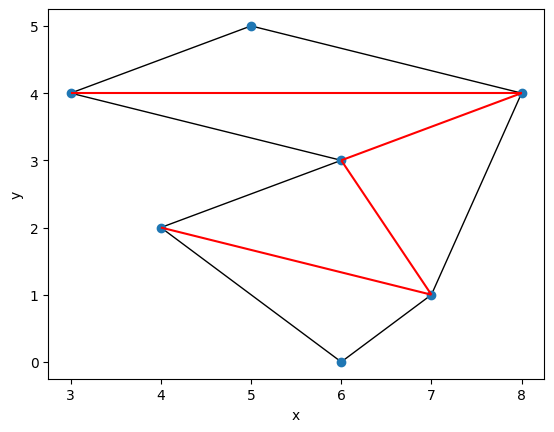

In [182]:
tri_ex1, triangles = triangulation(polygon_example_1)
draw_polygon_triangulation(polygon_example_1, tri_ex1)

In [183]:
def draw_triangles(triangles, polygon):
    vis = Visualizer()
    
    for a, b, c in triangles:
        vis.add_polygon([polygon[a], polygon[b], polygon[c]], fill = False)
    
    return vis

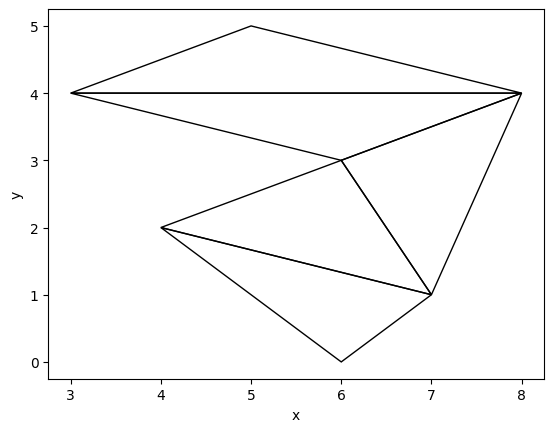

In [184]:
vis = draw_triangles(triangles, polygon_example_1)
vis.show()

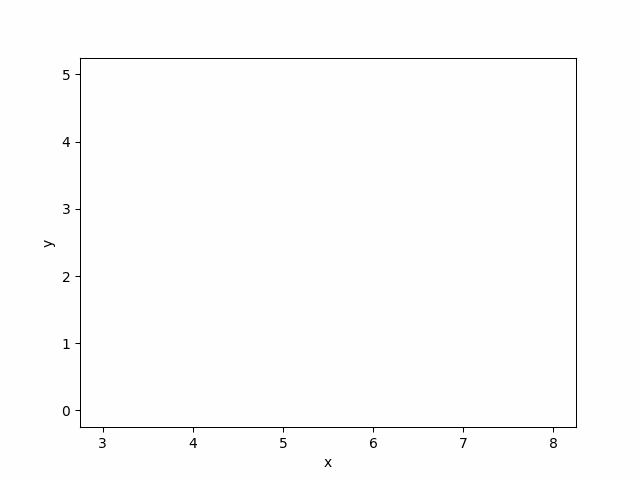

In [185]:
vis.show_gif()